In [13]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import random

In [14]:
#Load GDP data 
df_GDP = pd.read_csv('./1.1.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df_GDP['ags5'] = np.where(df_GDP.ags5.str.len() == 4, '0' + df_GDP['ags5'], df_GDP['ags5'])
#df_GDP.set_index('ags5', drop=True, inplace=True)
df_GDP = df_GDP.drop("Unnamed: 0", axis=1)
df_GDP = df_GDP.rename(columns={'time_stamp': 'year', 'value':'gdp'})
df_GDP['year'] = pd.to_datetime(df_GDP['year'], format = '%Y')
df_GDP['year'] = df_GDP['year'].dt.year
df_GDP

,ags5,year,gdp
0,01001,2008,3105.912
1,01001,2009,2993.960
2,01001,2010,3013.761
3,01001,2011,3047.700
4,01001,2012,3124.752
...,...,...,...
4406,16077,2014,1869.001
4407,16077,2015,1849.958
4408,16077,2016,1928.277
4409,16077,2017,1972.319


In [15]:
#Load UR data 
df_UR = pd.read_csv('./../../final_dfs/for_modeling/df_final_date_long_2007.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df_UR['ags5'] = np.where(df_UR.ags5.str.len() == 4, '0' + df_UR['ags5'], df_UR['ags5'])
#df_UR.set_index('ags5', drop=True, inplace=True)
#df_UR = df_UR.drop("Unnamed: 0", axis=1)
df_UR['date'] = pd.to_datetime(df_UR['date'], format = '%Y-%m-%d')
df_UR = df_UR[df_UR['variable'] == 'unemployment_rate']
df_UR = df_UR.rename(columns={'value': 'unemployment_rate'})
df_UR = df_UR[['ags5','ags2', 'date', 'unemployment_rate']]
df_UR['year'] = df_UR['date'].dt.year
df_UR

,ags5,ags2,date,unemployment_rate,year
532211,01001,1,2007-05-01,12.7,2007
532212,01001,1,2007-06-01,12.2,2007
532213,01001,1,2007-07-01,12.5,2007
532214,01001,1,2007-08-01,12.3,2007
532215,01001,1,2007-09-01,11.7,2007
...,...,...,...,...,...
599975,16077,16,2021-01-01,7.3,2021
599976,16077,16,2021-02-01,7.3,2021
599977,16077,16,2021-03-01,7.2,2021
599978,16077,16,2021-04-01,6.9,2021


In [16]:
df_full = pd.merge(df_GDP, df_UR, left_on=['ags5','year'], right_on=['ags5','year'])

In [17]:
df = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df = df[['ags5','2019_population']]

In [18]:
df_full = pd.merge(df_full, df, left_on=['ags5'], right_on=['ags5'])
df_full

,ags5,year,gdp,ags2,date,unemployment_rate,2019_population
0,01001,2008,3105.912,1,2008-01-01,11.6,90164
1,01001,2008,3105.912,1,2008-02-01,11.5,90164
2,01001,2008,3105.912,1,2008-03-01,11.4,90164
3,01001,2008,3105.912,1,2008-04-01,11.4,90164
4,01001,2008,3105.912,1,2008-05-01,11.4,90164
...,...,...,...,...,...,...,...
52927,16077,2018,2017.299,16,2018-08-01,7.4,89393
52928,16077,2018,2017.299,16,2018-09-01,7.3,89393
52929,16077,2018,2017.299,16,2018-10-01,7.3,89393
52930,16077,2018,2017.299,16,2018-11-01,7.3,89393


In [19]:
df_full['gdp_per_capita'] = df_full['gdp']/df_full['2019_population']
df_full

,ags5,year,gdp,ags2,date,unemployment_rate,2019_population,gdp_per_capita
0,01001,2008,3105.912,1,2008-01-01,11.6,90164,0.034447
1,01001,2008,3105.912,1,2008-02-01,11.5,90164,0.034447
2,01001,2008,3105.912,1,2008-03-01,11.4,90164,0.034447
3,01001,2008,3105.912,1,2008-04-01,11.4,90164,0.034447
4,01001,2008,3105.912,1,2008-05-01,11.4,90164,0.034447
...,...,...,...,...,...,...,...,...
52927,16077,2018,2017.299,16,2018-08-01,7.4,89393,0.022567
52928,16077,2018,2017.299,16,2018-09-01,7.3,89393,0.022567
52929,16077,2018,2017.299,16,2018-10-01,7.3,89393,0.022567
52930,16077,2018,2017.299,16,2018-11-01,7.3,89393,0.022567


In [20]:
df_full_mean_UR = df_full.groupby(['ags5','ags2','year']).mean()
df_full_mean_UR

gdp  unemployment_rate  2019_population  gdp_per_capita
ags5  ags2 year                                                              
01001 1    2008  3105.912          11.408333            90164        0.034447
           2009  2993.960          12.883333            90164        0.033206
           2010  3013.761          12.700000            90164        0.033425
           2011  3047.700          11.858333            90164        0.033802
           2012  3124.752          11.358333            90164        0.034656
...                   ...                ...              ...             ...
16077 16   2014  1869.001          10.941667            89393        0.020908
           2015  1849.958          10.391667            89393        0.020695
           2016  1928.277           9.191667            89393        0.021571
           2017  1972.319           8.583333            89393        0.022063
           2018  2017.299           7.725000            89393        0.022567

[4411 rows x 4 columns]

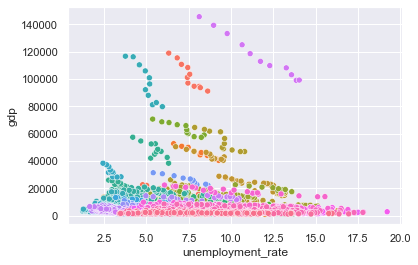

In [21]:
g = sns.scatterplot(data=df_full_mean_UR, x="unemployment_rate", y="gdp", hue="ags5")
g.legend_.remove()

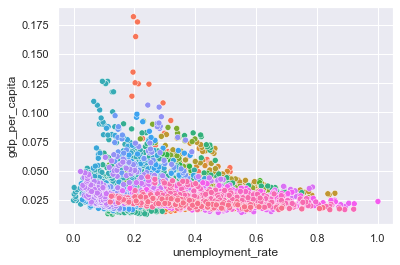

In [30]:
g = sns.scatterplot(data=df_full_mean_UR, x="unemployment_rate", y="gdp_per_capita", hue="ags5")
g.legend_.remove()

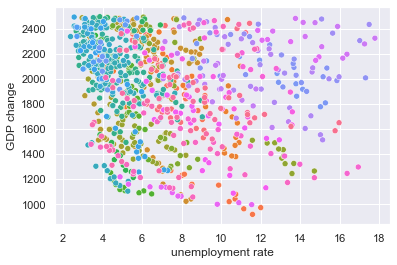

In [22]:
df_full_small = df_full[df_full['gdp'] < 2500]
df_full_mean_UR_small = df_full_small.groupby(['ags5','ags2','year']).mean()
df_full_mean_UR_small
g = sns.scatterplot(data=df_full_mean_UR_small, x="unemployment_rate", y="gdp", hue="ags5")
g.set(xlabel='unemployment rate', ylabel='GDP change')
g.legend_.remove()

In [23]:
sample_args = random.sample(list(set(df_full['ags5'])), 30)
df_sample = df_full[df_full['ags5'].isin(sample_args)]
df_sample_mean_UU = df_sample.groupby(['ags5','ags2','year']).mean()

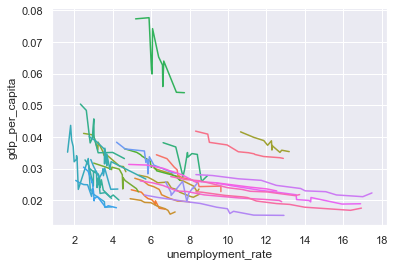

In [31]:
g = sns.lineplot(data=df_sample_mean_UU, x="unemployment_rate", y="gdp_per_capita",  hue="ags5")
g.legend_.remove()

In [25]:
scaler = MinMaxScaler()
df_full_mean_UR[['gdp','unemployment_rate']] = scaler.fit_transform(df_full_mean_UR[['gdp','unemployment_rate']])
df_full_mean_UR

gdp  unemployment_rate  2019_population  gdp_per_capita
ags5  ags2 year                                                              
01001 1    2008  0.015127           0.565137            90164        0.034447
           2009  0.014353           0.647195            90164        0.033206
           2010  0.014490           0.636996            90164        0.033425
           2011  0.014725           0.590172            90164        0.033802
           2012  0.015258           0.562355            90164        0.034656
...                   ...                ...              ...             ...
16077 16   2014  0.006575           0.539175            89393        0.020908
           2015  0.006443           0.508577            89393        0.020695
           2016  0.006985           0.441817            89393        0.021571
           2017  0.007289           0.407974            89393        0.022063
           2018  0.007600           0.360223            89393        0.022567

[4411 rows x 4 columns]

In [26]:
X = df_full.drop(['year','gdp'], axis=1)
Y = df_full['gdp']
X

,ags5,ags2,date,unemployment_rate,2019_population,gdp_per_capita
0,01001,1,2008-01-01,11.6,90164,0.034447
1,01001,1,2008-02-01,11.5,90164,0.034447
2,01001,1,2008-03-01,11.4,90164,0.034447
3,01001,1,2008-04-01,11.4,90164,0.034447
4,01001,1,2008-05-01,11.4,90164,0.034447
...,...,...,...,...,...,...
52927,16077,16,2018-08-01,7.4,89393,0.022567
52928,16077,16,2018-09-01,7.3,89393,0.022567
52929,16077,16,2018-10-01,7.3,89393,0.022567
52930,16077,16,2018-11-01,7.3,89393,0.022567


In [27]:
X['date'] = X['date'].astype(str)
#X['ags2'] = X['ags2'].astype(str)
X['ags5'] = X['ags5'].astype(str)
X = pd.get_dummies(data=X, drop_first=True)

In [28]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [29]:
#stats.summary(regr, X, Y, X.columns)

In [32]:
df_full_mean_UR['gdp_change'] = df_full_mean_UR['gdp'] - df_full_mean_UR.groupby(['ags5','ags2'])['gdp'].shift(1)
df_full_mean_UR['ur_change'] = df_full_mean_UR['unemployment_rate'] - df_full_mean_UR.groupby(['ags5','ags2'])['unemployment_rate'].shift(1)
df_full_mean_UR
df_full_mean_UR['gdp_per_capita_change'] = df_full_mean_UR['gdp_per_capita'] - df_full_mean_UR.groupby(['ags5','ags2'])['gdp_per_capita'].shift(1)

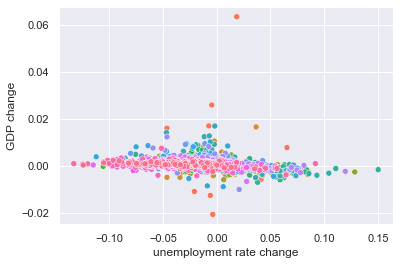

In [33]:
g = sns.scatterplot(data=df_full_mean_UR, x="ur_change", y="gdp_per_capita_change", hue="ags5")
g.set(xlabel='unemployment rate change', ylabel='GDP change')
g.legend_.remove()

In [15]:
#df_full_mean_UR = df_full_mean_UR.reset_index(drop=False)
sample_args = random.sample(list(set(df_full['ags5'])), 10)
df_sample = df_full_mean_UR[df_full_mean_UR['ags5'].isin(sample_args)]

KeyError: 'ags5'

In [1]:
g = sns.scatterplot(data=df_sample, x="ur_change", y="gdp_change", hue="ags5")
g.legend_.remove()

NameError: name 'sns' is not defined

In [16]:
df_full_mean_UR['gdp_change_percent'] = df_full_mean_UR['gdp_change']/df_full_mean_UR.groupby(['ags5','ags2'])['gdp'].shift(1)
df_full_mean_UR['ur_change_percent'] = df_full_mean_UR['ur_change']/ df_full_mean_UR.groupby(['ags5','ags2'])['unemployment_rate'].shift(1)
df_full_mean_UR

gdp  unemployment_rate  gdp_change  ur_change  \
ags5  ags2 year                                                       
01001 1    2008  3105.912          11.408333         NaN        NaN   
           2009  2993.960          12.883333    -111.952   1.475000   
           2010  3013.761          12.700000      19.801  -0.183333   
           2011  3047.700          11.858333      33.939  -0.841667   
           2012  3124.752          11.358333      77.052  -0.500000   
...                   ...                ...         ...        ...   
16077 16   2014  1869.001          10.941667     152.773  -0.400000   
           2015  1849.958          10.391667     -19.043  -0.550000   
           2016  1928.277           9.191667      78.319  -1.200000   
           2017  1972.319           8.583333      44.042  -0.608333   
           2018  2017.299           7.725000      44.980  -0.858333   

                 gdp_change_percent  ur_change_percent  
ags5  ags2 year                                         
01001 1    2008                 NaN                NaN  
           2009           -0.036045           0.129291  
           2010            0.006614          -0.014230  
           2011            0.011261          -0.066273  
           2012            0.025282          -0.042164  
...                             ...                ...  
16077 16   2014            0.089017          -0.035268  
           2015           -0.010189          -0.050267  
           2016            0.042336          -0.115477  
           2017            0.022840          -0.066183  
           2018            0.022806          -0.100000  

[4411 rows x 6 columns]

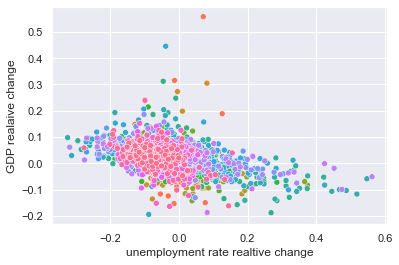

In [18]:
g = sns.scatterplot(data=df_full_mean_UR, x="ur_change_percent", y="gdp_change_percent", hue="ags5")
g.set(xlabel='unemployment rate realtive change', ylabel='GDP realaive change')
g.legend_.remove()

In [ ]:
sample_args = random.sample(list(set(df_full['ags5'])), 30)
df_sample = df_full_mean_UR[df_full_mean_UR['ags5'].isin(sample_args)]
g = sns.scatterplot(data=df_sample, x="ur_change", y="gdp_change_percent", hue="ags5")
g.legend_.remove()